In [1]:
import copy
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy import stats
from scipy.constants import c
from scipy.stats import median_abs_deviation, norm

from csromer.base import Dataset
from csromer.dictionaries import DiscreteWavelet, UndecimatedWavelet
from csromer.io import Reader, Writer
from csromer.objectivefunction import L1, TSV, TV, Chi2, OFunction
from csromer.optimization import FISTA, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers import Gridding
from csromer.transformers.dfts import NDFT1D, NUFFT1D
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [2]:
SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 19

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": 'pdflatex',  # default is xetex
    }
)

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

In [3]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = (residuals.real * residuals.real) + (residuals.imag * residuals.imag)
    else:
        data = residuals**2
    return np.sum(data)

In [4]:
def aicbic(residuals_coeffs, x_coeffs):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:
        df = np.count_nonzero(x)
    l = len(residuals)
    return l * np.log(rss / l) + 2 * df, l * np.log(rss / l) + df * np.log(l)

In [5]:
def aicbic(residuals, x):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
        lcoeffs = 2 * len(x)
    else:
        df = np.count_nonzero(x)
        lcoeffs = len(x)
    l = len(residuals)
    print("len(coeffs):", lcoeffs)
    print("l:", l)
    print("df:", df)
    print("rss:", rss)
    print("rss/l", rss / l)
    print("log(rss/l)", np.log(rss / l))
    print("log(l)", np.log(l))
    return l * np.log(rss / l) + 2 * df, l * np.log(rss / l) + df * np.log(l)

In [6]:
np.random.seed(666)

In [7]:
#nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)  # VLA
nu = np.linspace(start=0.89e9, stop=1.681e9, num=1000)  # MeerKAT Larry's config
#nu = np.linspace(start=0.58e9, stop=2.50e9, num=512) # MIGHTEE config

In [8]:
peak_thinsource = 1.
peak_thicksource = 1.

In [9]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=0.0)

In [10]:
#140 JVLA
# 95 MeerKAT
thicksource = FaradayThickSource(
    nu=nu, s_nu=peak_thicksource, phi_fg=90., phi_center=200., spectral_idx=0.0
)

In [11]:
#thinsource.l2_ref = thinsource.calculate_l2ref()

In [12]:
#thicksource.l2_ref = thicksource.calculate_l2ref()

In [13]:
thinsource.simulate()
thicksource.simulate()

In [14]:
simsource = thicksource

In [15]:
simsource.l2_ref = simsource.calculate_l2ref()

In [16]:
simsource.l2_ref

0.06008617981851801

In [17]:
original_source = copy.deepcopy(simsource)

In [18]:
remove_channels_seed = int(time.time())
remove_channels_seed

1665226333

In [19]:
#simsource.remove_channels(0.1, np.random.RandomState(1648643337))
#simsource.remove_channels(0.1, np.random.RandomState(1648650067))
simsource.remove_channels(0.2)

In [20]:
peak_thinsource

1.0

In [21]:
applied_noise = 0.2 * peak_thinsource

In [22]:
applied_noise * 1000.0

200.0

In [23]:
#simsource.data = np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m) + 1j * np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m)

In [24]:
simsource.apply_noise(applied_noise)

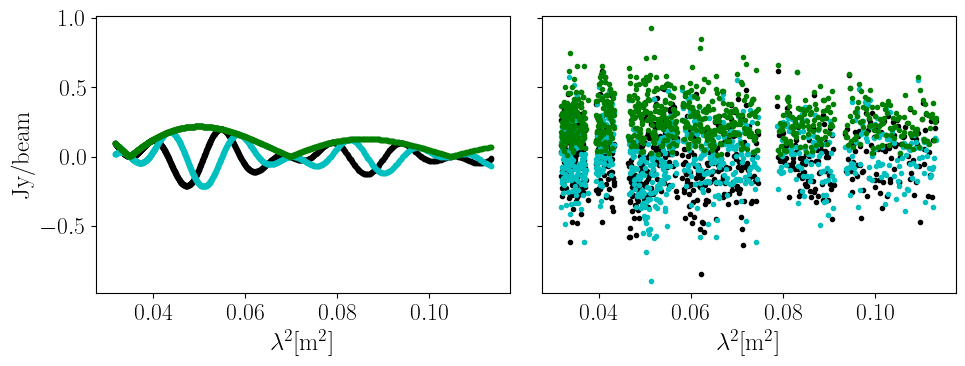

In [25]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(original_source.lambda2, original_source.data.real, 'k.', label=r"Stokes $Q$")
ax[0].plot(original_source.lambda2, original_source.data.imag, 'c.', label=r"Stokes $U$")
ax[0].plot(original_source.lambda2, np.abs(original_source.data), 'g.', label=r"$|P|$")
ax[0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0].set_ylabel(r'Jy/beam')

ax[1].plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
ax[1].plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
ax[1].plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
ax[1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
plt.tight_layout()

In [26]:
sigma_qu = 0.5 * (np.std(simsource.data.real) + np.std(simsource.data.imag))
sigma_qu

0.21790253529988834

In [27]:
dataset = simsource

In [28]:
parameter = Parameter()
original_parameter = Parameter()

In [29]:
original_parameter.calculate_cellsize(dataset=original_source, oversampling=8)

FWHM of the main peak of the RMTF: 42.422 rad/m^2
Maximum recovered width structure: 98.774 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21189.543


In [30]:
parameter.calculate_cellsize(dataset=dataset, oversampling=8)

FWHM of the main peak of the RMTF: 42.527 rad/m^2
Maximum recovered width structure: 98.774 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 16989.340


In [31]:
nufft_original = NUFFT1D(dataset=original_source, parameter=original_parameter)
nufft = NUFFT1D(dataset=dataset, parameter=parameter)

In [32]:
dft = NDFT1D(dataset=dataset, parameter=parameter)
dft_original = NDFT1D(dataset=original_source, parameter=original_parameter)

In [33]:
F_dirty = dft.backward(dataset.data)
F_dirty_original = dft_original.backward(original_source.data)

rmtf_original = dft_original.RMTF()
rmtf = dft.RMTF()

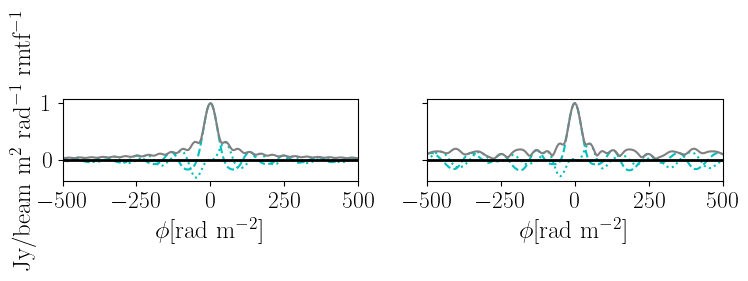

In [34]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(original_parameter.phi, rmtf_original.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(original_parameter.phi, rmtf_original.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(original_parameter.phi, np.abs(rmtf_original), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-500, 500])

ax[1].plot(parameter.phi, rmtf.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, rmtf.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(rmtf), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-500, 500])

plt.tight_layout()

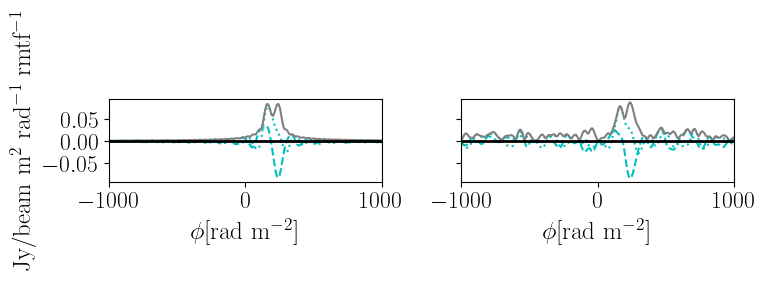

In [35]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-1000, 1000])

plt.tight_layout()

In [36]:
F_dirty_nufft = nufft.backward(dataset.data)

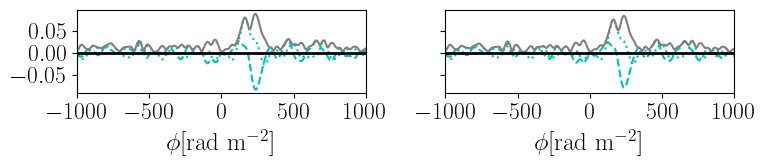

In [37]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter.phi, F_dirty_nufft.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, F_dirty_nufft.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(F_dirty_nufft), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-1000, 1000])

plt.tight_layout()

In [38]:
idx_noise = np.where(np.abs(parameter.phi) > 0.8 * parameter.max_faraday_depth)
noise_F = 0.5 * (
    median_abs_deviation(F_dirty[idx_noise].real, scale="normal") +
    median_abs_deviation(F_dirty[idx_noise].imag, scale="normal")
)
noise_F

0.006880700207869959

In [39]:
dataset.theo_noise

0.007071067811865476

In [40]:
noise_from_w = 1.0 / np.sqrt(np.sum(dataset.w))
noise_from_w * 1000.0

7.071067811865476

In [41]:
wav = None
#wav = DiscreteWavelet(wavelet_name="haar", mode="periodization")
#wav = UndecimatedWavelet(wavelet_name="sym2", mode="periodization", append_signal=True)

In [42]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    print(wav.calculate_max_level(parameter.data))
    parameter.data = wav.decompose(parameter.data)
    if wav.append_signal is True:
        parameter.data[0:2 * len(F_dirty)] = 0.0
    plt.plot(parameter.data)

In [43]:
len(parameter.data)

12736

In [44]:
np.sqrt(2) * np.mean(dataset.sigma) * 1000.0

282.8427124746191

In [45]:
#lambda_l1 = np.sqrt(2*dataset.m + (4*np.sqrt(2*dataset.m))) * dataset.theo_noise
#lambda_l1 = np.sqrt(dataset.m + (2*np.sqrt(2*dataset.m))) * np.sqrt(2) * dataset.theo_noise
#lambda_l1 = np.sqrt(dataset.m) * noise_F
if wav is not None:
    lambda_l1 = np.sqrt(dataset.m +
                        2 * np.sqrt(dataset.m)) * 2. * np.sqrt(2) * np.mean(dataset.sigma)
else:
    lambda_l1 = np.sqrt(dataset.m + 2 * np.sqrt(dataset.m)) * np.sqrt(2) * np.mean(dataset.sigma)

lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)

F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [46]:
lambda_l1

8.278012043938684

In [47]:
if wav is not None:
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=2.0 * dataset.theo_noise,
        verbose=False
    )
else:
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=dataset.theo_noise,
        verbose=False
    )
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()
print(obj)

686.1334321308854


In [48]:
if wav is not None:
    plt.plot(X.data)

In [49]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

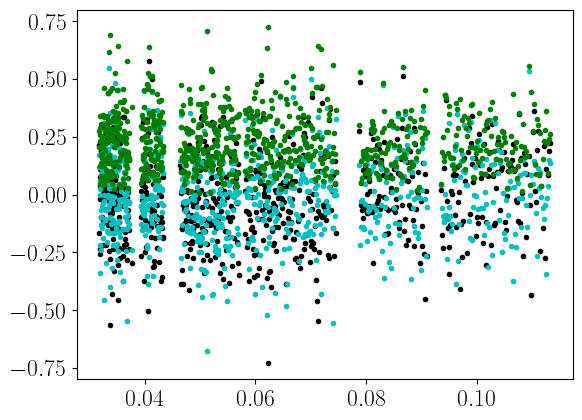

In [50]:
plt.plot(dataset.lambda2, dataset.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.residual), 'g.', label=r"$|P|$")

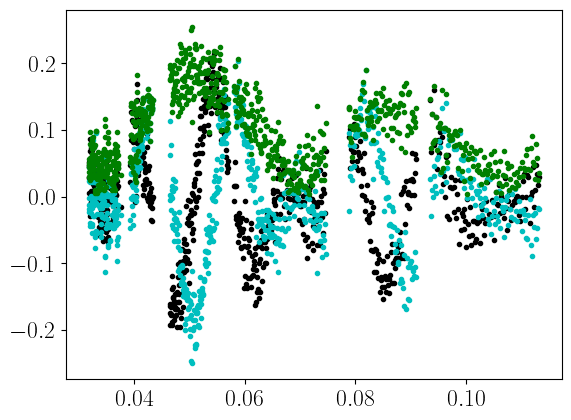

In [51]:
plt.plot(dataset.lambda2, dataset.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.model_data), 'g.', label=r"$|P|$")

In [52]:
sigma_res = 0.5 * (np.std(dataset.residual.real) + np.std(dataset.residual.imag))

In [53]:
sigma_res * 1000.0

185.2028133704679

In [54]:
F_residual = dft.backward(dataset.residual)

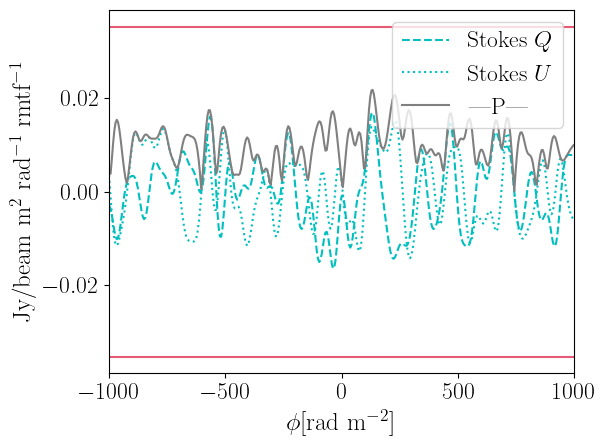

In [55]:
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [56]:
rms_residual = 0.5 * (np.std(F_residual.real) + np.std(F_residual.imag))
rms_residual * 1000.0

6.212743930518627

In [57]:
dataset.theo_noise * 1000.0

7.071067811865476

In [58]:
noise_F * 1000.0

6.8807002078699595

In [59]:
applied_noise * 1000.0

200.0

In [60]:
sigma_qu * 1000.0

217.90253529988834

In [61]:
model_2 = dft.backward(dataset.model_data)

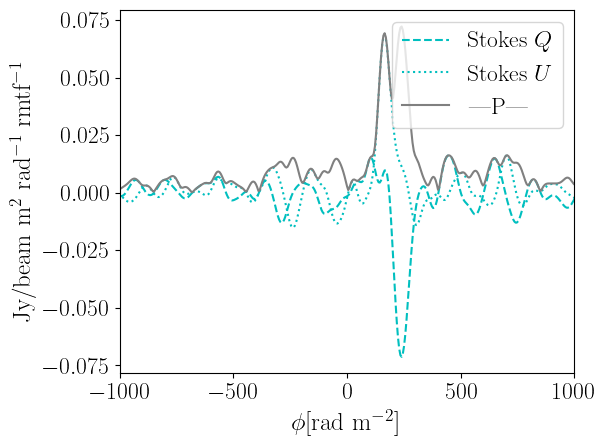

In [62]:
plt.plot(parameter.phi, model_2.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, model_2.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(model_2), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [63]:
residual_faraday = F_dirty - model_2

In [64]:
conv_model = X.convolve() + F_residual

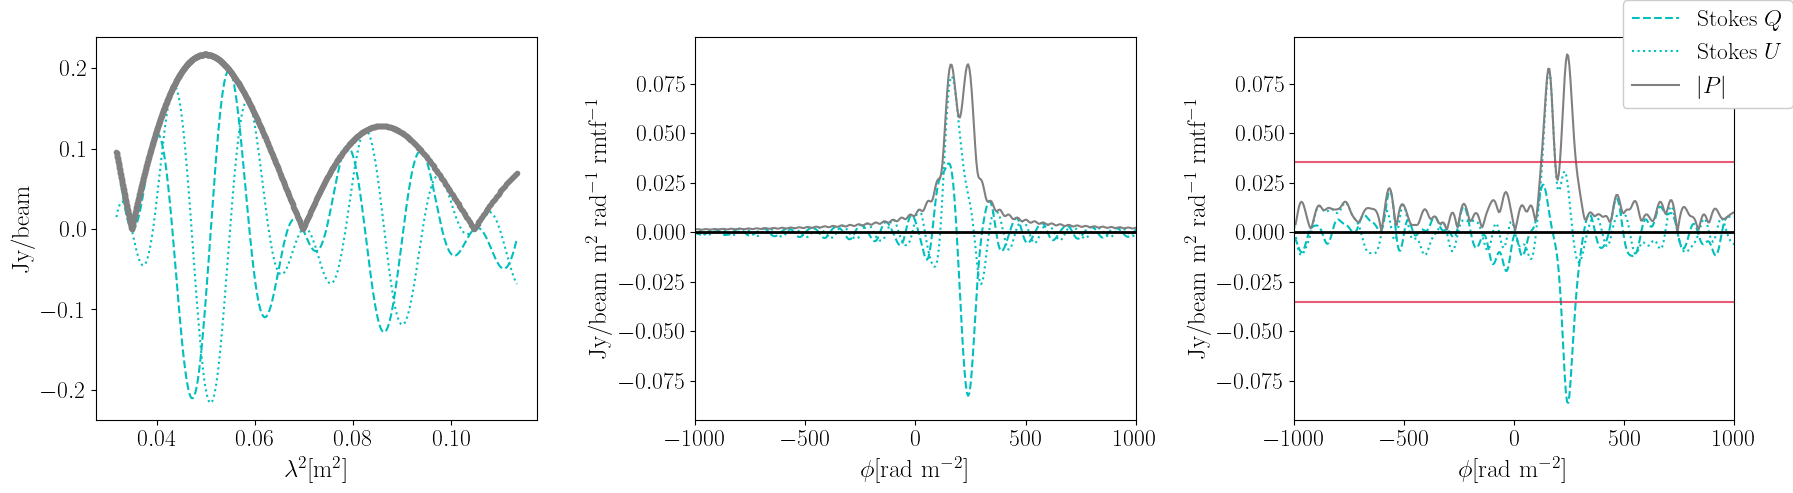

In [65]:
fig = plt.figure(figsize=(18, 5))
#fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(original_source.lambda2, original_source.data.real, 'c--', label=r"Stokes $Q$")
ax1.plot(original_source.lambda2, original_source.data.imag, 'c:', label=r"Stokes $U$")
ax1.plot(original_source.lambda2, np.abs(original_source.data), '.', color="grey", label=r"$|P|$")
ax1.set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax1.set_ylabel(r'Jy/beam')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
ax2.plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
ax2.plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
ax2.plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
#ax2.axhline (y = 5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
#ax2.axhline (y = -5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
ax2.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax2.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax2.set_xlim([-1000, 1000])

ax3 = fig.add_subplot(1, 3, 3, sharex=ax2, sharey=ax2)
ax3.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax3.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax3.plot(parameter.phi, np.abs(conv_model), '-', c='grey', label=r"$|P|$")

ax3.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
#ax3.set_xlim([-1000,1000])
ax3.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
ax3.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
ax3.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax3.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')

handles, labels = ax3.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="upper right", borderaxespad=0)
legend.get_frame().set_alpha(1.0)
fig.tight_layout()
fig.savefig("thinthicksource.pdf", dpi=500)

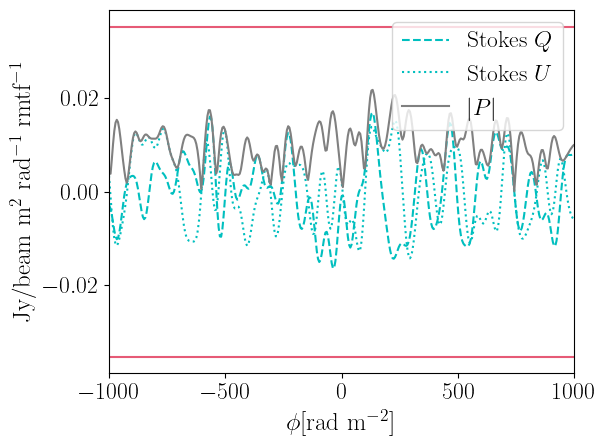

In [66]:
plt.plot(parameter.phi, residual_faraday.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, residual_faraday.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(residual_faraday), '-', c='grey', label=r"$|P|$")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

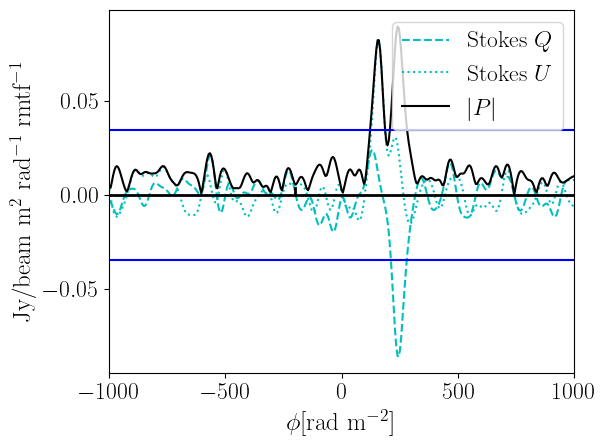

In [67]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
plt.xlim([-1000, 1000])
plt.axhline(y=5 * noise_F, color='b')
plt.axhline(y=-5 * noise_F, color='b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("restored.png", dpi=100)

In [68]:
np.nanmax(np.abs(conv_model))

0.08976250982114709

In [69]:
P = np.sqrt(np.max(np.abs(conv_model))**2 - (2.3 * rms_residual**2))

In [70]:
parameter.rmtf_fwhm / (2 * P / rms_residual)

1.4798714886078115

In [71]:
residual_1d = np.concatenate([residual_faraday.real, residual_faraday.imag])
#residual_1d = np.concatenate([dataset.residual.real, dataset.residual.imag])
stat, p = stats.jarque_bera(residual_1d)

In [72]:
print("stat={0:.3f}, p={1:.3f}".format(stat, p))

stat=99.733, p=0.000


In [73]:
p

0.0

In [74]:
if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

Probably not Gaussian


In [75]:
residual_all = np.concatenate([F_residual.real, F_residual.imag]) * 1000.0

In [76]:
frequency, bins = np.histogram(residual_all, bins="auto", density=True)
frequency /= np.max(frequency)
xmin = np.min(bins)
xmax = np.max(bins)
dist = np.abs(xmax - xmin)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0.0, dataset.theo_noise * 1000.0)
p /= np.max(p)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='row', figsize=(20, 10))

# Data
ax[0, 0].plot(dataset.lambda2, dataset.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 0].plot(dataset.lambda2, dataset.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 0].plot(dataset.lambda2, np.abs(dataset.data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 0].set_ylabel(r'mJy/beam')
ax[0, 0].title.set_text("Data")

ax[1, 0].plot(parameter.phi, F_dirty.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 0].plot(parameter.phi, F_dirty.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 0].plot(parameter.phi, np.abs(F_dirty) * 1000.0, 'k-', label=r"|P|")
ax[1, 0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 0].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 0].set_xlim([-1000, 1000])

# Model
ax[0, 1].plot(dataset.lambda2, dataset.model_data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 1].plot(dataset.lambda2, dataset.model_data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 1].plot(dataset.lambda2, np.abs(dataset.model_data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 1].set_ylabel(r'mJy/beam')
ax[0, 1].title.set_text("Model")
# Model
ax[1, 1].plot(parameter.phi, X.data.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 1].plot(parameter.phi, X.data.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 1].plot(parameter.phi, np.abs(X.data) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1, 1].set_xlim([-1000, 1000])

# Residual

ax[0, 2].plot(dataset.lambda2, dataset.residual.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 2].plot(dataset.lambda2, dataset.residual.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 2].plot(dataset.lambda2, np.abs(dataset.residual) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 2].set_ylabel(r'mJy/beam')
ax[0, 2].title.set_text("Residuals")

ax[0, 3].get_shared_x_axes().remove(ax[0, 3])
# Create and assign new ticker
xticker = matplotlib.axis.Ticker()
ax[0, 3].xaxis.major = xticker

# The new ticker needs new locator and formatters
xloc = matplotlib.ticker.AutoLocator()
xfmt = matplotlib.ticker.ScalarFormatter()

ax[0, 3].xaxis.set_major_locator(xloc)
ax[0, 3].xaxis.set_major_formatter(xfmt)

ax[0, 3].bar(bins[:-1], frequency, width=dist / 20, alpha=0.3)
ax[0, 3].plot(x, p, 'crimson', linewidth=2)

ax[1, 2].plot(parameter.phi, F_residual.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 2].plot(parameter.phi, F_residual.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 2].plot(parameter.phi, np.abs(F_residual) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 2].axhline(y=5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 2].axhline(y=-5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 2].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 2].set_xlim([-1000, 1000])

ax[1, 3].plot(parameter.phi, conv_model.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 3].plot(parameter.phi, conv_model.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 3].plot(parameter.phi, np.abs(conv_model) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 3].axhline(y=5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 3].axhline(y=-5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 3].set_xlim([-1000, 1000])
ax[1, 3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 3].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 3].title.set_text("Restored")

title = "Scenario 3 - "
"""
if isinstance(dataset, FaradayThinSource):
    title += "Scenario 1 - "
elif isinstance(dataset, FaradayThickSource):
    title += "Scenario 2 - "
else:
    title += "Scenario 3 - "
"""
if wav is None:
    title += "Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "{0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "{0} undecimated wavelet ".format(wav.wavelet_name)
"""
if wav is None:
    title += "- Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "- Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "- Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} undecimated wavelet ".format(wav.wavelet_name)

if (dataset.w == dataset.w[0]).all():
    title += "uniform weights equal to {0:.3f}".format(dataset.w[0])   
else:
    title += "natural weights "




"""
fig.suptitle(title)
fig.tight_layout()